<a href="https://colab.research.google.com/github/Zerldas/Translate-EN-to-FR-Project/blob/main/NLP_Project_Translate_EN_to_FR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python3 --version

Python 3.12.12


**Kiểm tra và tải về các thư viện cần thiết trước khi thực hiện project**

In [3]:
# Tải về các thư viện cần thiết trước khi thực hiện project
!pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.12.0
anywidget                           

In [4]:
!pip install spacy

!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 114.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 89.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


***Danh sách các thư viện sẽ được sử dụng***

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import random
import torch.nn.functional as F
from datetime import datetime
from wordcloud import WordCloud
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

Thiết lập GPU

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

Device: cuda


Thiết lại tokenizer

In [7]:
tokenize_en = spacy.load("en_core_web_sm")
tokenize_fr = spacy.load("fr_core_news_sm")

In [8]:
def tokenizer_en(sentence):
  return [token.text.lower()
          for token in tokenize_en(sentence)
          if token.text.strip()]

def tokenizer_fr(sentence):
  return [token.text.lower()
          for token in tokenize_fr(sentence)
          if token.text.strip()]

***Tiến hành phân tích dữ liệu***

In [9]:
# Khai báo dường đẫn dữ liệu train
train_en_path = "/content/drive/MyDrive/EN-FR/data/train/train.en"
train_fr_path = "/content/drive/MyDrive/EN-FR/data/train/train.fr"
# Dữ liệu valiation
val_en_path = "/content/drive/MyDrive/EN-FR/data/val/val.en"
val_fr_path = "/content/drive/MyDrive/EN-FR/data/val/val.fr"
# Dữ liệu test sử dụng tạp test 2016 flick
test_en_path = "/content/drive/MyDrive/EN-FR/data/test/test_2016_flickr.en"
test_fr_path = "/content/drive/MyDrive/EN-FR/data/test/test_2016_flickr.fr"

In [10]:
def load_data(en_path, fr_path):
    with open(en_path, encoding="utf-8") as f_en:
        en_lines = [line.strip() for line in f_en]

    with open(fr_path, encoding="utf-8") as f_fr:
        fr_lines = [line.strip() for line in f_fr]

    assert len(en_lines) == len(fr_lines), "EN-FR line count mismatch!"
    return en_lines, fr_lines

In [11]:
train_en_lines, train_fr_lines = load_data(train_en_path, train_fr_path)
val_en_lines, val_fr_lines = load_data(val_en_path, val_fr_path)
test_en_lines, test_fr_lines = load_data(test_en_path, test_fr_path)

print("=== TẬP TRAIN ===")
print(f"Tiếng Anh: {len(train_en_lines)}")
print(f"Tiếng Pháp: {len(train_fr_lines)}")
print(f"Tổng: {len(train_en_lines) + len(train_fr_lines)}\n")

print("=== TẬP VALIDATION ===")
print(f"Tiếng Anh: {len(val_en_lines)}")
print(f"Tiếng Pháp: {len(val_fr_lines)}")
print(f"Tổng: {len(val_en_lines) + len(val_fr_lines)}\n")

print("=== TẬP TEST ===")
print(f"Tiếng Anh: {len(test_en_lines)}")
print(f"Tiếng Pháp: {len(test_fr_lines)}")
print(f"Tổng: {len(test_en_lines) + len(test_fr_lines)}")

=== TẬP TRAIN ===
Tiếng Anh: 29000
Tiếng Pháp: 29000
Tổng: 58000

=== TẬP VALIDATION ===
Tiếng Anh: 1014
Tiếng Pháp: 1014
Tổng: 2028

=== TẬP TEST ===
Tiếng Anh: 1000
Tiếng Pháp: 1000
Tổng: 2000


In [12]:
# Xem xét độ dài câu (token)
def get_lengths(sentences, tokenizer):
    return [len(tokenizer(s)) for s in sentences]

train_len_en = get_lengths(train_en_lines, tokenize_en)
train_len_fr = get_lengths(train_fr_lines, tokenize_fr)

print(train_len_en)
print(train_len_fr)

[11, 12, 9, 15, 9, 15, 8, 14, 12, 11, 10, 16, 9, 16, 8, 17, 13, 15, 10, 16, 12, 17, 9, 11, 16, 22, 10, 12, 9, 16, 11, 11, 8, 16, 10, 22, 10, 19, 6, 21, 8, 13, 8, 12, 10, 15, 11, 17, 14, 16, 15, 20, 8, 20, 8, 18, 11, 21, 7, 11, 11, 15, 12, 12, 14, 17, 8, 17, 12, 15, 12, 9, 9, 17, 16, 18, 12, 14, 8, 12, 10, 12, 10, 16, 8, 13, 8, 20, 10, 13, 16, 11, 18, 15, 10, 19, 10, 19, 13, 19, 12, 13, 9, 14, 13, 20, 10, 13, 10, 13, 14, 16, 12, 11, 8, 13, 10, 17, 10, 11, 14, 19, 14, 9, 13, 14, 8, 17, 8, 19, 18, 14, 15, 19, 12, 23, 11, 16, 14, 22, 13, 17, 8, 18, 8, 14, 9, 11, 10, 11, 9, 13, 10, 10, 8, 13, 10, 14, 12, 20, 10, 16, 13, 8, 11, 12, 10, 12, 16, 24, 15, 11, 10, 18, 11, 13, 13, 12, 11, 10, 13, 19, 10, 14, 8, 12, 9, 13, 10, 13, 8, 11, 9, 20, 13, 20, 21, 9, 7, 16, 12, 14, 10, 14, 10, 13, 11, 14, 11, 10, 9, 11, 10, 14, 9, 10, 11, 16, 10, 10, 10, 21, 9, 10, 8, 34, 8, 17, 12, 12, 15, 33, 13, 14, 11, 12, 9, 35, 13, 17, 8, 21, 10, 15, 10, 8, 8, 15, 7, 15, 13, 14, 11, 8, 10, 12, 10, 16, 11, 15, 7, 12, 

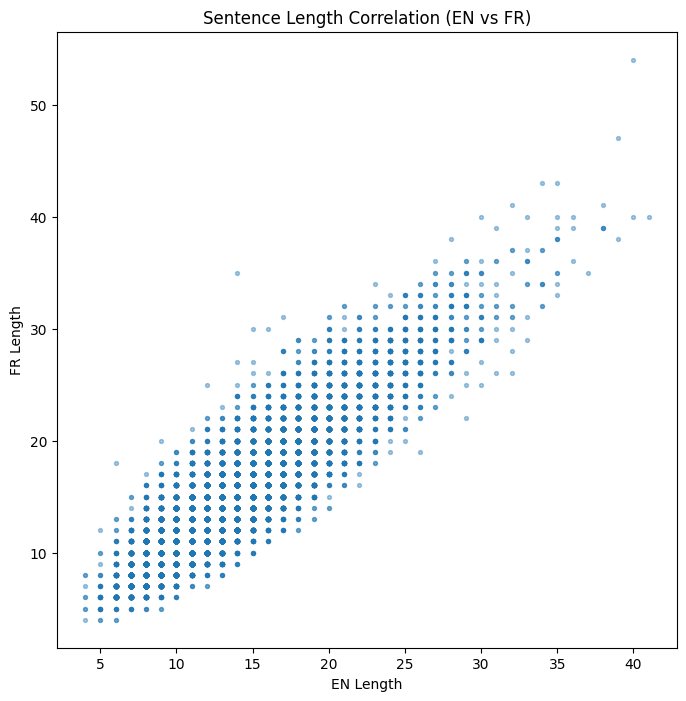

In [13]:
# Biểu đồ xem xét độ dài câu
plt.figure(figsize=(8,8))
plt.scatter(train_len_en, train_len_fr, s=8, alpha=0.4)
plt.xlabel("EN Length")
plt.ylabel("FR Length")
plt.title("Sentence Length Correlation (EN vs FR)")
plt.show()

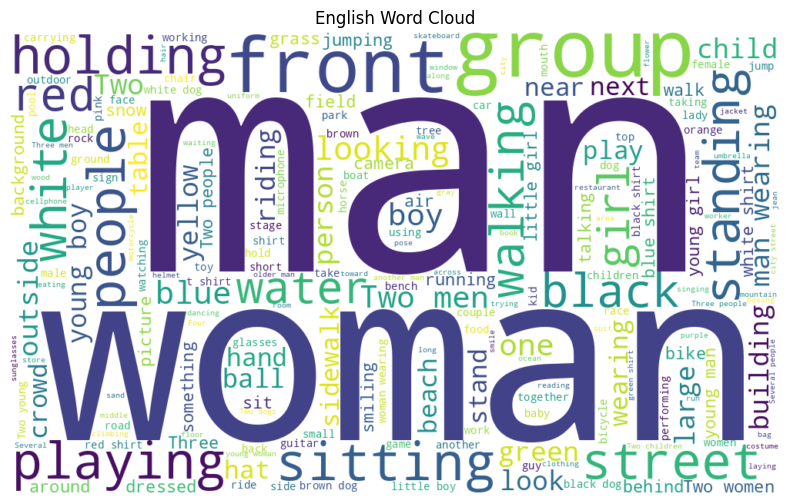

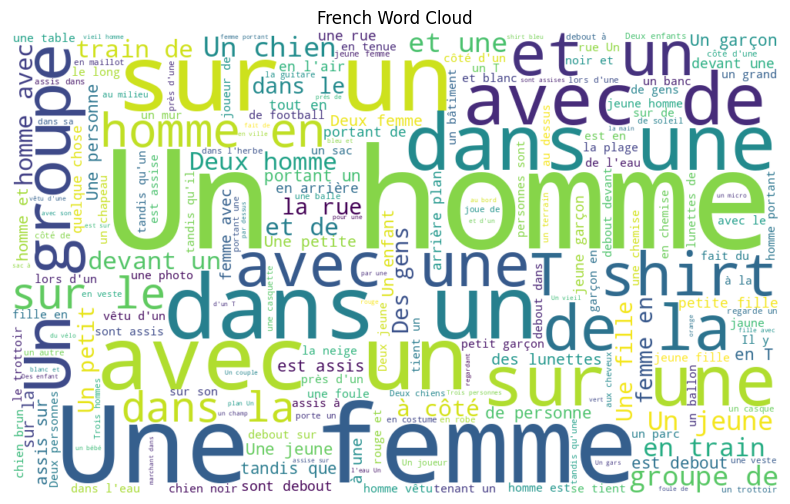

In [14]:
en_text = " ".join(train_en_lines)
fr_text = " ".join(train_fr_lines)

wordcloud_en = WordCloud(width=1000, height=600, background_color='white').generate(en_text)
wordcloud_fr = WordCloud(width=1000, height=600, background_color='white').generate(fr_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis("off")
plt.title("English Word Cloud")
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_fr, interpolation='bilinear')
plt.axis("off")
plt.title("French Word Cloud")
plt.show()

Xây dựng vocabulary

In [15]:
index_token = [
  "<pad>", #Padding giúp câu có cùng độ dài
  "<unk>", #Unknow đánh dấu từ không có nghĩa
  "<sos>", #Từ ở đầu câu
  "<eos>"  #TỪ ở cuối câu
]

PAD_IDX = index_token.index("<pad>")   # 0
UNK_IDX = index_token.index("<unk>")   # 1
SOS_IDX = index_token.index("<sos>")   # 2
EOS_IDX = index_token.index("<eos>")   # 3

In [16]:
def build_vocab(sentences, tokenizer, max_size=10000000):
  counter = Counter()

  for sen in sentences:
    tokens = tokenizer(sen)
    counter.update(tokens)

  most_common = counter.most_common(max_size - 4)
  # Danh sách từ
  idx_token = index_token + [word for word, _ in most_common]
  # map token → id
  token_to_index = {token: idx for idx, token in enumerate(idx_token)}

  return token_to_index, index_token, counter

In [17]:
# Build vocab
vocab_en, index_en, counter_en = build_vocab(train_en_lines, tokenize_en, max_size=10000)
vocab_fr, index_fr, counter_fr = build_vocab(train_fr_lines, tokenize_fr, max_size=10000)

print("EN vocab size:", len(vocab_en))
print("FR vocab size:", len(vocab_fr))

EN vocab size: 10000
FR vocab size: 10000


In [18]:
# Đưa vocab về dạng số
def numericalize(sentence, tokenizer, vocab):
  tokens = ["<sos>"] + tokenizer(sentence) + ["<eos>"]
  return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

In [19]:
class Translate_Dataset(torch.utils.data.Dataset):
  def __init__(self, en_sentences, fr_sentences):
    self.en_sentences = en_sentences
    self.fr_sentences = fr_sentences

  def __len__(self):
    return len(self.en_sentences)

  def __getitem__(self, index):
    en_sentence = self.en_sentences[index]
    fr_sentence = self.fr_sentences[index]

    # chuyển sang dạng số
    source_ids = numericalize(en_sentence, tokenizer_en, vocab_en)
    target_ids = numericalize(fr_sentence, tokenizer_fr, vocab_fr)

    # độ dài câu nguồn để pack_padded_sequence
    length = len(source_ids)

    return torch.tensor(source_ids), torch.tensor(target_ids), length

In [20]:
def collate_fn(batch):
  source_batch, target_batch, source_lengths = zip(*batch)
  source_lengths = list(source_lengths)
  sorted_indices = sorted(range(len(source_lengths)), key=lambda i: -source_lengths[i])

  source_batch = [source_batch[i] for i in sorted_indices]
  target_batch = [target_batch[i] for i in sorted_indices]
  source_lengths = [source_lengths[i] for i in sorted_indices]

  source_batch = pad_sequence(
      source_batch, batch_first=True, padding_value=PAD_IDX
  )

  target_batch = pad_sequence(
      target_batch, batch_first=True, padding_value=PAD_IDX
  )

  # convert source_lengths to tensor
  source_lengths = torch.tensor(source_lengths, dtype=torch.long)

  return source_batch, target_batch, source_lengths

In [21]:
# Tạo DataLoaders
train = Translate_Dataset(train_en_lines, train_fr_lines)
val = Translate_Dataset(val_en_lines, val_fr_lines)
test = Translate_Dataset(test_en_lines, test_fr_lines)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size=32 ,shuffle=False, collate_fn=collate_fn)

Encoder

In [35]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size,
                num_layers=1, dropout=0.5, bidirectional=True):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(dropout)
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(
      embed_size,
      hidden_size,
      num_layers=num_layers,
      dropout=dropout if num_layers > 1 else 0,
      batch_first=True,
    )

  def forward(self, source, lengths):
    if isinstance(lengths, list):
      lengths = torch.tensor(lengths, dtype=torch.long, device=source.device)

    lengths_cpu = lengths.cpu()

    embedded = self.dropout(self.embedding(source))

    packed = nn.utils.rnn.pack_padded_sequence(
      embedded,
      lengths_cpu,
      batch_first=True,
      enforce_sorted=False
    )

    packed_outputs, (hidden, cell) = self.lstm(packed)

    outputs, _ = nn.utils.rnn.pad_packed_sequence(
        packed_outputs, batch_first=True
    )

    return outputs, (hidden, cell)

Decoder

In [23]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, pad_idx):
    super().__init__()

    self.embedding = nn.Embedding(
        vocab_size,
        embed_size,
        padding_idx=pad_idx
    )

    self.lstm = nn.LSTM(
        embed_size,
        hidden_size,
        num_layers=num_layers,
        dropout=dropout if num_layers > 1 else 0.0,
        batch_first=True
    )

    self.fc_out = nn.Linear(hidden_size, vocab_size)

  def forward(self, token, hidden, cell):
    token = token.unsqueeze(1)
    embedded = self.embedding(token)
    output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
    prediction = self.fc_out(output.squeeze(1))

    return prediction, hidden, cell

Seq2Seq

In [24]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, pad_index):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.pad_index = pad_index

  def forward(self, source, target, source_lengths, teacher_forcing_ratio=0.5):
    batch_size, target_sequence_length = target.size()
    vocabulary_size = self.decoder.fc_out.out_features
    device = source.device

    outputs = torch.zeros(batch_size, target_sequence_length, vocabulary_size, device=device)

    encoder_outputs, (hidden_state, cell_state) = self.encoder(source, source_lengths)

    decoder_input = target[:, 0]

    for timestep in range(1, target_sequence_length):

      decoder_output, hidden_state, cell_state = self.decoder(
        decoder_input, hidden_state, cell_state
      )

      outputs[:, timestep] = decoder_output
      use_teacher_forcing = random.random() < teacher_forcing_ratio
      predicted_token = decoder_output.argmax(1)
      decoder_input = target[:, timestep] if use_teacher_forcing else predicted_token

    return outputs

Build Model

In [25]:
# Khai báo thông số model
INPUT_SIZE = len(vocab_en)
OUTPUT_SIZE = len(vocab_fr)
ENC_EMB_SIZE = 256
DEC_EMB_SIZE = 256
HID_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = 32
N_EPOCHS = 10
LEARNING_RATE = 0.001

In [26]:
#  Thiết lập Early Stopping
class EarlyStopping:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.best_loss = float('inf')
    self.counter = 0
    self.should_stop = False

  def __call__(self, val_loss):
    # Nếu cải thiện
    if val_loss < self.best_loss - self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      print(f"No improvement ({self.counter}/{self.patience})")

      if self.counter >= self.patience:
        self.should_stop = True
        print("\n Early Stopping Triggered!")

In [37]:
encoder = Encoder(INPUT_SIZE, ENC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
decoder = Decoder(OUTPUT_SIZE, DEC_EMB_SIZE, HID_SIZE, NUM_LAYERS, DROPOUT, PAD_IDX).to(DEVICE)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer,
  mode='min',
  factor=0.5,
  patience=2,
  threshold=1e-4,
  cooldown=0,
  min_lr=1e-6,
)

Training Loop

In [33]:
def train_epoch():
  model.train()
  total_loss = 0

  for source, target, source_lengths in train_loader:
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_lengths = source_lengths.to(DEVICE)

    optimizer.zero_grad()

    output = model(source, target, source_lengths)

    # Bỏ <sos> trong cả output và target
    output = output[:, 1:].contiguous().view(-1, output.size(-1))
    target = target[:, 1:].contiguous().view(-1)

    loss = criterion(output, target)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(train_loader)

In [29]:
# Tính Valid
def eval_epoch():
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for source, target, source_lengths in val_loader:
      source = source.to(DEVICE)
      target = target.to(DEVICE)
      source_lengths = source_lengths.to(DEVICE)

      output = model(
        source,
        target,
        source_lengths,
        teacher_forcing_ratio=0.5
      )

      output = output[:, 1:].contiguous().view(-1, output.size(-1))
      target = target[:, 1:].contiguous().view(-1)

      loss = criterion(output, target)
      total_loss += loss.item()

  return total_loss / len(val_loader)

In [38]:
# Train model
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
  train_loss = train_epoch()
  val_loss = eval_epoch()

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  print("\n" + "="*50)
  print(f"EPOCH {epoch+1}/{N_EPOCHS} — {datetime.now().strftime('%H:%M:%S')}")
  print("-"*50)
  print(f"   Train Loss : {train_loss:.4f}")
  print(f"   Val Loss : {val_loss:.4f}")
  print("="*50)

  # Early stopping kiểm tra val_loss
  early_stopping(val_loss)
  if early_stopping.should_stop:
    print(f"\n EARLY STOPPING IN {epoch}")
    break

# Lưu mô hình
torch.save(model.state_dict(), "best_model.pth")


EPOCH 1/10 — 15:30:40
--------------------------------------------------
   Train Loss : 0.1806
   Val Loss : 0.1419

EPOCH 2/10 — 15:37:43
--------------------------------------------------
   Train Loss : 0.1417
   Val Loss : 0.1453
No improvement (1/3)

EPOCH 3/10 — 15:44:49
--------------------------------------------------
   Train Loss : 0.1413
   Val Loss : 0.1402

EPOCH 4/10 — 15:51:52
--------------------------------------------------
   Train Loss : 0.1410
   Val Loss : 0.1441
No improvement (1/3)

EPOCH 5/10 — 15:58:54
--------------------------------------------------
   Train Loss : 0.1405
   Val Loss : 0.1397
No improvement (2/3)

EPOCH 6/10 — 16:05:56
--------------------------------------------------
   Train Loss : 0.1403
   Val Loss : 0.1393
No improvement (3/3)

 Early Stopping Triggered!

 EARLY STOPPING IN 5


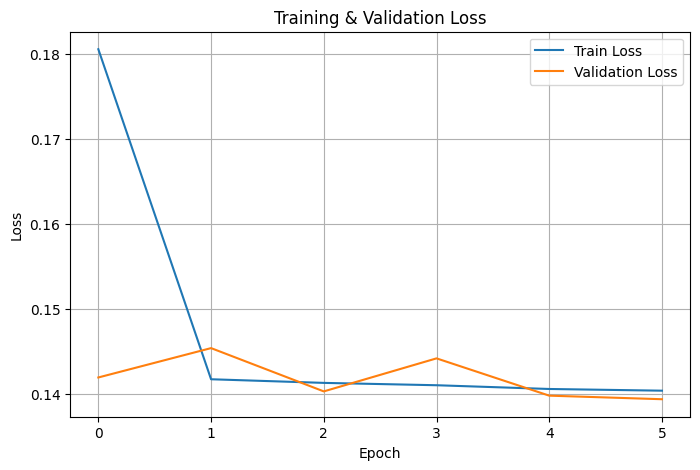

In [39]:
def plot_losses(train_losses, val_losses):
  plt.figure(figsize=(8, 5))
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training & Validation Loss")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_losses(train_losses, val_losses)

In [40]:
# Hàm translate
def translate(sentence):
  model.eval()
  source_ids = numericalize(sentence, tokenizer_en, vocab_en)
  source_tensor = torch.tensor(source_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
  source_lengths = [source_tensor.size(1)]
  idx_to_fr = list(vocab_fr.keys())

  with torch.no_grad():
    hidden, cell = model.encoder(source_tensor, source_lengths)
    token = torch.tensor([SOS_IDX], dtype=torch.long, device=DEVICE)

    result_tokens = []

    for _ in range(50):
      output, (hidden, cell) = model.decoder(token, hidden, cell)

      next_token = output.argmax(1)
      idx = next_token.item()

      if idx == EOS_IDX:
        break

      result_tokens.append(idx_to_fr[idx])
      token = next_token

  return " ".join(result_tokens)

In [41]:
# Hàm tính BLEU
def compute_bleu(n=100):
  smoothie = SmoothingFunction().method4
  scores = []

  for i in range(n):
    pred_sentence = translate(test_en_lines[i]).lower()
    pred_tokens = pred_sentence.split()

    ref_tokens = tokenizer_fr(test_fr_lines[i].lower())

    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    scores.append(bleu)

  return sum(scores) / len(scores)

print("BLEU:", compute_bleu(100))

AttributeError: 'tuple' object has no attribute 'dim'

In [ ]:
# Dịch thử năm câu
for i in range(5):
  print("EN :", test_en_lines[i])
  print("PRED:", translate(test_en_lines[i]))
  print("REF :", test_fr_lines[i])
  print()

In [ ]:
!mv ./result ./drive/MyDrive/EN-FR/

Phần Nâng Cao

Thêm Cơ Chế Attention

In [ ]:
class BahdanauAttention(nn.Module):
  def __init__(self, enc_hid_dim, dec_hid_dim):
    super().__init__()
    # enc_hid_dim: kích thước encoder output (nếu bidirectional thì = enc_hid * 2)
    # dec_hid_dim: kích thước hidden decoder
    self.W_encoder = nn.Linear(enc_hid_dim, dec_hid_dim)
    self.W_decoder = nn.Linear(dec_hid_dim, dec_hid_dim)
    self.v = nn.Linear(dec_hid_dim, 1, bias=False)

  def forward(self, decoder_hidden, encoder_outputs, mask=None):
    decoder_hidden = decoder_hidden.unsqueeze(1)

    energy = torch.tanh(
        self.W_encoder(encoder_outputs) + self.W_decoder(decoder_hidden)
    )

    score = self.v(energy).squeeze(2)

    if mask is not None:
        score = score.masked_fill(mask == 0, -1e9)

    attn_weights = F.softmax(score, dim=1)

    return attn_weights

In [ ]:
class BahdanauDecoder(nn.Module):
  def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout=0.1):
    super().__init__()

    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.attention = BahdanauAttention(enc_hid_dim, dec_hid_dim)

    self.rnn = nn.GRU(emb_dim + enc_hid_dim, dec_hid_dim, batch_first=True)

    self.fc_out = nn.Linear(emb_dim + enc_hid_dim + dec_hid_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input_token, last_hidden, encoder_outputs, mask=None):
    embedded = self.dropout(self.embedding(input_token)).unsqueeze(1)  # [batch,1,emb]

    # Prepare decoder hidden: [batch, dec_hid_dim]
    dec_hidden = last_hidden.squeeze(0)

    # attention weights: [batch, src_len]
    attn_weights = self.attention(dec_hidden, encoder_outputs, mask)

    # context vector: [batch, enc_hid_dim]
    context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)

    # RNN input
    rnn_input = torch.cat([embedded.squeeze(1), context], dim=1).unsqueeze(1)

    # GRU
    output, hidden = self.rnn(rnn_input, last_hidden)
    output = output.squeeze(1)  # [batch, dec_hid]

    # final projection
    logits = self.fc_out(torch.cat([output, context, embedded.squeeze(1)], dim=1))

    return logits, hidden, attn_weights

In [ ]:
class Seq2SeqWithAttention(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def create_mask(self, source_tokens, padding_index):
    return (source_tokens != padding_index).to(self.device)

  def forward(
    self,
    source_tokens,
    source_lengths,
    target_tokens=None,
    teacher_forcing_ratio=0.5,
    padding_index=None
  ):

    batch_size = source_tokens.size(0)
    if padding_index is None:
      padding_index = 0

    encoder_outputs, encoder_hidden_states = self.encoder(
      source_tokens, source_lengths
    )

    attention_mask = self.create_mask(source_tokens, padding_index)

    # --- CHUẨN HÓA HIDDEN ĐỂ CHO VÀO DECODER ---
    if isinstance(encoder_hidden_states, tuple):
      # Trường hợp encoder là LSTM
      encoder_hidden_tensor = encoder_hidden_states[0]
    else:
      encoder_hidden_tensor = encoder_hidden_states

    # Nếu encoder là bidirectional
    if encoder_hidden_tensor.size(0) >= 2 and encoder_hidden_tensor.size(0) % 2 == 0:
      last_forward_state = encoder_hidden_tensor[-2, :, :]
      last_backward_state = encoder_hidden_tensor[-1, :, :]

      decoder_initial_hidden = torch.tanh(
        torch.cat((last_forward_state, last_backward_state), dim=1)
      ).unsqueeze(0)

    else:
      decoder_initial_hidden = encoder_hidden_tensor[-1, :, :].unsqueeze(0)

    if target_tokens is not None:
      target_length = target_tokens.size(1)
    else:
      target_length = 50  # độ dài tối đa khi suy luận

    outputs = torch.zeros(
        batch_size, target_length, self.decoder.output_dim
    ).to(self.device)

    # Token đầu vào đầu tiên cho decoder là token <sos>
    if target_tokens is not None:
        decoder_input_token = target_tokens[:, 0]
    else:
        sos_index = 3
        decoder_input_token = torch.LongTensor(
          [sos_index] * batch_size
        ).to(self.device)

    decoder_hidden = decoder_initial_hidden

    for t in range(1, target_length):
        output_logits, decoder_hidden, attention_weights = self.decoder(
          decoder_input_token,
          decoder_hidden,
          encoder_outputs,
          mask=attention_mask
        )

        outputs[:, t, :] = output_logits

        # Teacher forcing
        use_teacher_forcing = (
          target_tokens is not None
          and torch.rand(1).item() < teacher_forcing_ratio
        )

        predicted_token = output_logits.argmax(1)

        decoder_input_token = (
          target_tokens[:, t] if use_teacher_forcing else predicted_token
        )

    return outputs


In [ ]:
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(DEVICE)
attention = BahdanauAttention(HID_DIM).to(DEVICE)
decoder = DecoderBahdanau(OUTPUT_DIM, EMB_DIM, HID_DIM, attention).to(DEVICE)
model = Seq2SeqWithAttention(encoder, decoder, PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)